In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
import statistics as stat
from scipy.stats import vonmises, linregress
import math
#import pandas as pd
import pycircular as pyc
from functions_file import *
from scipy import interpolate
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
import scipy.special as sp
from functools import partial
from matplotlib.animation import FuncAnimation
import os
import glob
import subprocess
import pandas as pd

In [2]:


# Path to the folder containing the experiment output files
folder_path = 'velocity_tuning_exp_outputs/'

# Get the list of all files in the folder
files = glob.glob(os.path.join(folder_path, '*'))

# Loop through the files and delete them
for file in files:
    try:
        os.remove(file)  # Removes the file
        print(f"Deleted: {file}")
    except Exception as e:
        print(f"Error deleting file {file}: {e}")

Deleted: velocity_tuning_exp_outputs/mse_data.csv
Deleted: velocity_tuning_exp_outputs/rate_max_vel_data.csv
Deleted: velocity_tuning_exp_outputs/sorted_theta_HD_data.csv
Deleted: velocity_tuning_exp_outputs/neuro_pref_dir_data.csv
Deleted: velocity_tuning_exp_outputs/spike_count_n30_data.csv
Deleted: velocity_tuning_exp_outputs/model_info.txt


In [3]:
num_runs = 5 # Number of runs

experiment_script = "vel_tuning_exp_script.py"  # Experiment script to run
output_dir = "velocity_tuning_exp_outputs"
os.makedirs(output_dir, exist_ok=True)

# Run the experiment multiple times and save data in separate files
for run in range(num_runs):
    # Run the experiment
    subprocess.run(["python", experiment_script])
    print(f"Run {run+1} completed")



Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed


Tuning model type

In [4]:
# Path to the model information file
model_info_path = "velocity_tuning_exp_outputs/model_info.txt"

# Check if the file exists and read the model type
if os.path.exists(model_info_path):
    with open(model_info_path, "r") as f:
        model_info = f.read().strip()  # Read and remove any trailing newline/whitespace
    print(f"{model_info}")
else:
    print("Model information not found.")

Model used: NO-TUNING


Reading and storing data in DataFrame objects

In [5]:
# Now, let's load the data and calculate the mean
neuro_pref_dir_file_path = os.path.join(output_dir, "neuro_pref_dir_data.csv")
rate_vel_file_path = os.path.join(output_dir, "rate_max_vel_data.csv")
mse_file_path = os.path.join(output_dir, "mse_data.csv")  
spikec_n30_file_path = os.path.join(output_dir, "spike_count_n30_data.csv")
sorted_theta_HD_file_path = os.path.join(output_dir, "sorted_theta_HD_data.csv")
# Read the data from the CSV files
rate_max_vel_data_df = pd.read_csv(rate_vel_file_path)
neuro_pref_dir_data_df = pd.read_csv(neuro_pref_dir_file_path)
mse_data_df = pd.read_csv(mse_file_path)
spikec_n30_data_df = pd.read_csv(spikec_n30_file_path)
sorted_theta_HD_data_df = pd.read_csv(sorted_theta_HD_file_path)

Plotting of the neurons' preffered directions

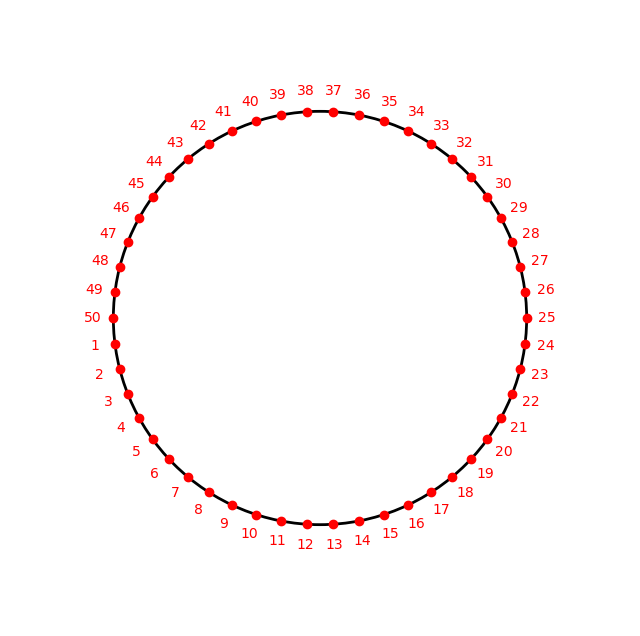

In [6]:
neuro_pref_dir_angles = neuro_pref_dir_data_df.iloc[:, 0]  # Adjust angles

# Convert to Cartesian coordinates for plotting
x = np.cos(neuro_pref_dir_angles)
y = np.sin(neuro_pref_dir_angles)

# Plotting the circle
fig, ax = plt.subplots(figsize=(8,8))
circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2)
ax.add_artist(circle)

# Plot the points and add labels
for i, (xi, yi) in enumerate(zip(x, y), start=1):
    ax.plot(xi, yi, 'ro')  # Red dot
    ax.text(xi * 1.1, yi * 1.1, str(i), color='red', fontsize=10, ha='center', va='center')

# Adjust plot limits and appearance
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal', adjustable='datalim')
ax.axis('off')  # Hide axes for a cleaner look

plt.show()

Statistics on the rates from the velocity tuning

In [7]:
rate_vel_row_means = rate_max_vel_data_df.mean(axis=1).values 

var_rows = np.var(rate_max_vel_data_df.values, axis=1)
mean_var_rows = np.mean(var_rows)
var_var_rows = np.var(var_rows)


print('Mean variance over the rates :', mean_var_rows)
print('Variance over the variance of the rates : ', var_var_rows)

print(rate_max_vel_data_df.values.shape)
print(np.min(rate_max_vel_data_df.values))

Mean variance over the rates : 0.0
Variance over the variance of the rates :  0.0
(10001, 5)
10.0


Exampe of a tuning curve for a neuron

In [8]:
N_neurons = 50

a = 0
k = 5

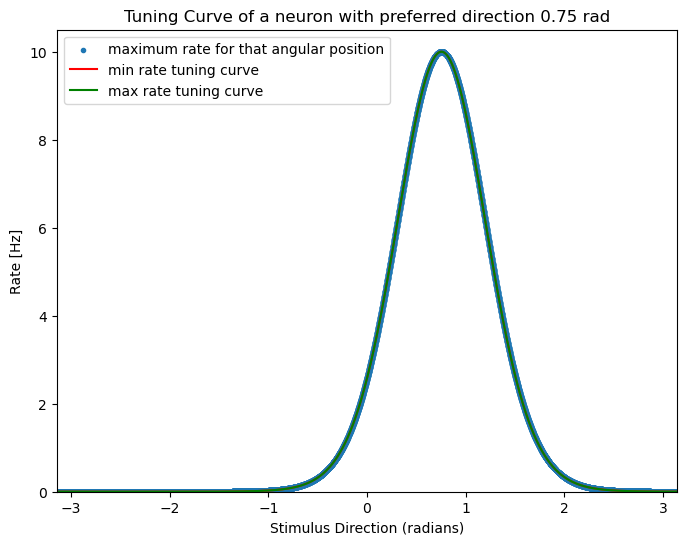

In [9]:
N_points_function = len(rate_vel_row_means)
x_points = np.linspace(-np.pi, np.pi, N_points_function)

tuning_curves = np.zeros((N_neurons, N_points_function)) #initialization

for i in range(0, N_neurons):

    pref_HD_eachneuron = neuro_pref_dir_angles[i]
    pref_dir_vector_eachneuro= pref_HD_eachneuron*np.ones_like(x_points)
    tuning_curves[i, :] = VonMisesFunction(a,rate_vel_row_means* 10**(-3),k,x_points,pref_HD_eachneuron)

# Plot all tuning curves
'''plt.figure(figsize=(8, 6))
for i in range(N_neurons):
    plt.plot(x_points, tuning_curves[i, :], label=f'Neuron {i+1} (Pref Dir: {neuro_pref_dir_angles[i]:.2f})')
'''

neuro_index = 30 

plt.figure(figsize=(8, 6))
#for j in range(num_runs):
tuning_curves_neuro30 = VonMisesFunction(a,rate_max_vel_data_df.values[:,1],k,x_points,neuro_pref_dir_angles[neuro_index])
plt.scatter(x_points, tuning_curves_neuro30, marker='.', label='maximum rate for that angular position')
plt.plot(x_points, VonMisesFunction(a,np.min(rate_max_vel_data_df.values),k,x_points,neuro_pref_dir_angles[neuro_index]), 'r', label='min rate tuning curve')
plt.plot(x_points, VonMisesFunction(a,np.max(rate_max_vel_data_df.values),k,x_points,neuro_pref_dir_angles[neuro_index]), 'g', label='max rate tuning curve')


# Adding labels and title
plt.xlabel('Stimulus Direction (radians)')
plt.ylabel('Rate [Hz]')
plt.xlim([-np.pi, np.pi])
plt.ylim([0, np.max(rate_max_vel_data_df.values)+0.5])
plt.title(f'Tuning Curve of a neuron with preferred direction {neuro_pref_dir_angles[30]:.2f} rad')
plt.legend()


# Display the plot
plt.show()


spike count realization for the same neuron above

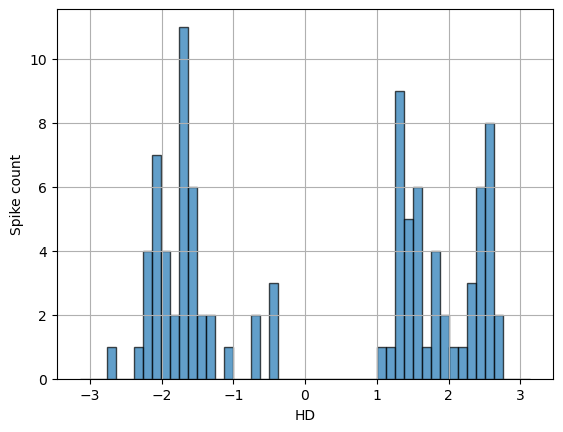

In [10]:
# Sum counts of 1 for each position (row)
counts_per_position = spikec_n30_data_df.sum(axis=1)

# Define the bins for positions from -np.pi to np.pi
positions =  sorted_theta_HD_data_df.values[:, 1]#np.linspace(-np.pi, np.pi, num=spikec_n30_data_df.shape[0])

# Create the histogram
plt.hist(positions, bins=50, weights=counts_per_position, edgecolor='black', alpha=0.7)

# Labeling the plot
plt.xlabel('HD')
plt.ylabel('Spike count')
#plt.title('Histogram of 1 Counts Across Positions')
plt.grid(True)
plt.show()

rescaling the rates data so it matches the unit of measure of the time interval for the poisson process

In [11]:
rate_max_vel_scaled_mHz = rate_max_vel_data_df.values * 10**(-3)

MSE calculated from the decoding

In [12]:
#REMEMEBR THAT THE MSE VALUE IS NORMlized for the total number of spikes in each experiment

print('mean normalized MSE from decoding : ', np.mean(mse_data_df.values))
print('variance of MSE over multiple decodings : ', np.var(mse_data_df.values))

mean normalized MSE from decoding :  3.172945847429617e-05
variance of MSE over multiple decodings :  1.0087611485218758e-12


PLOTS OF THE DIFFERENT TUNINGS

In [13]:
# Parameters
r_max = 0.01  # [ms] -> 10 spikes/sec peak firing rate
r_max_Hz = r_max * (10**3)  # Convert r_max to Hz (spikes per second)

# Maximum and minimum rates based on a 20% variation from the maximum
maximum = r_max_Hz + 0.2 * r_max_Hz
print('maximum rate is ', maximum)
minimum = r_max_Hz - 0.2 * r_max_Hz
print('minimum rate is ', minimum)

# Angular coefficient (from Finkelstein et al., 2019)
ang_coeff = (maximum - minimum) / (np.pi/3)

# Velocity data from -pi to pi
velocity_data = np.linspace(-np.pi/3, np.pi/3, 1000)



maximum rate is  12.0
minimum rate is  8.0


V-SHAPED TUNING

/var/folders/f7/d5fmkkj95vz3mq9xggxz6j900000gn/T/ipykernel_2301/1472681683.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


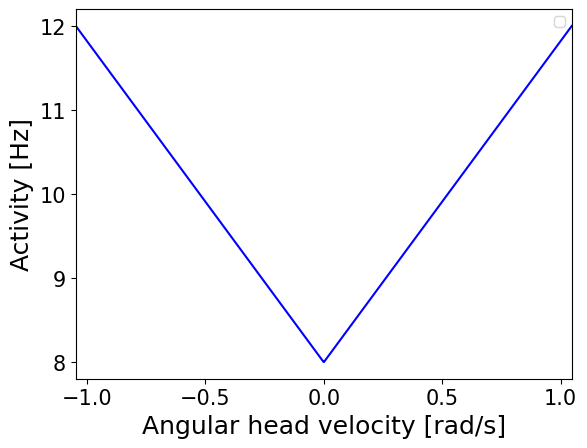

In [14]:
# Initialize the rate array
rate_max_depending_velocity = np.zeros_like(velocity_data)

# Apply the conditions from the given code
rate_max_depending_velocity[velocity_data < 0] = -ang_coeff * velocity_data[velocity_data < 0] + minimum
rate_max_depending_velocity[velocity_data > 0] = ang_coeff * velocity_data[velocity_data > 0] + minimum
rate_max_depending_velocity[velocity_data == 0] = minimum

# Plotting the data
plt.figure(figsize=(6.4, 4.8))
plt.plot(velocity_data, rate_max_depending_velocity, color='b')

# Labels and title
#plt.title('V-tuning')
plt.xlim([-np.pi/3, np.pi/3])
plt.xlabel('Angular head velocity [rad/s]', fontsize = 18)
plt.ylabel('Activity [Hz]', fontsize = 18)
plt.tick_params(axis='x', labelsize=15)  # x-axis tick labels
plt.tick_params(axis='y', labelsize=15)  # y-axis tick labels
plt.legend(loc='upper right')


# Show the plot
plt.show()

L-SHAPED TUNING

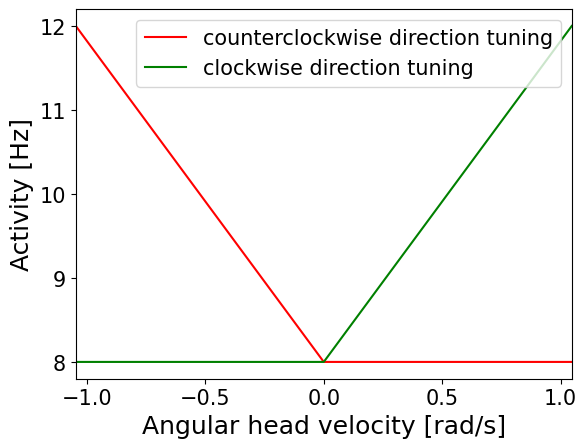

In [15]:
# Initialize the rate arrays for both cases
rate_case_1 = np.zeros_like(velocity_data)
rate_case_2 = np.zeros_like(velocity_data)

# First case: rate_max_depending_velocity for velocity < 0 is calculated with a negative slope,
# and rate_max_depending_velocity for velocity > 0 is set to the minimum.
rate_case_1[velocity_data < 0] = -ang_coeff * velocity_data[velocity_data < 0] + minimum
rate_case_1[velocity_data > 0] = minimum
rate_case_1[velocity_data == 0] = minimum

# Second case: rate_max_depending_velocity for velocity > 0 is calculated with a positive slope,
# and rate_max_depending_velocity for velocity < 0 is set to the minimum.
rate_case_2[velocity_data > 0] = ang_coeff * velocity_data[velocity_data > 0] + minimum
rate_case_2[velocity_data < 0] = minimum
rate_case_2[velocity_data == 0] = minimum

# Plotting both cases on the same graph
plt.figure(figsize=(6.4, 4.8))

# Plot first case (negative slope for negative velocities)
plt.plot(velocity_data, rate_case_1, label='counterclockwise direction tuning', color='r')

# Plot second case (positive slope for positive velocities)
plt.plot(velocity_data, rate_case_2, label='clockwise direction tuning', color='g')


# Labels and title
#plt.title('L-tuning')
plt.xlim([-np.pi/3, np.pi/3])
plt.xlabel('Angular head velocity [rad/s]', fontsize = 18)
plt.ylabel('Activity [Hz]', fontsize = 18)
plt.tick_params(axis='x', labelsize=15)  # x-axis tick labels
plt.tick_params(axis='y', labelsize=15)  # y-axis tick labels
plt.legend(loc='upper right', fontsize=15)


# Show the plot
plt.show()